# This notebook plots monthly mean precipitation on maps

In [1]:
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

In [2]:
# run_name = 'scream'
# run_name = 'mpi'
# run_name = 'nasa'
# run_name = 'nicam'
run_name = 'noaa'
# run_name = 'uk'

# Dictionary for official model names
model_name = {
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

if run_name == 'uk':
    xlabel_m = True
else:
    xlabel_m = False

test = ''
# test = '_ccs2h10k_pf0duration'

rootdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/'
obsdir = f'{rootdir}/obs/stats{test}/monthly/'
moddir = f'{rootdir}{run_name}/stats{test}/monthly/'
obsfile = f'{obsdir}mcs_rainmap_202002.nc'
modfile = f'{moddir}mcs_rainmap_202002.nc'

topfile = '/global/project/projectdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)

In [3]:
obsfile, modfile

('/global/cfs/cdirs/m1867/zfeng/dyamond-winter//obs/stats/monthly/mcs_rainmap_202002.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/noaa/stats/monthly/mcs_rainmap_202002.nc')

# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [4]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))
ter

<xarray.DataArray 'z' (latitude: 489, longitude: 1440)>
array([[-0.19099763, -0.2824136 ,  0.17526372, ...,  1.1824327 ,
         0.35849398,  0.26687884],
       [-0.19099763,  0.54152507,  0.35849398, ...,  2.2812166 ,
         1.3656629 ,  0.9994015 ],
       [-1.656043  , -0.9235203 ,  0.08384776, ...,  7.134229  ,
         0.9077864 , -0.55725896],
       ...,
       [ 0.35849398,  0.17526372,  0.17526372, ..., -0.46564385,
        -0.3740287 ,  0.17526372],
       [-0.3740287 , -0.0993825 ,  0.08384776, ...,  0.35849398,
         0.17526372,  0.17526372],
       [-0.00776737,  0.26687884, -0.00776737, ...,  0.08384776,
         0.17526372,  0.54152507]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 61.0 60.75 60.5 60.25 ... -60.5 -60.75 -61.0
    time       datetime64[ns] 1979-01-01

In [6]:
# Read GPM data files
dsobs = xr.open_mfdataset(obsfile, concat_dim='time', combine='nested')
lon_obs = dsobs.lon
lat_obs = dsobs.lat
dsobs.load()

<xarray.Dataset>
Dimensions:                  (time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                     (time) datetime64[ns] 2020-02-01
  * lat                      (lat) float32 -59.95 -59.85 -59.75 ... 59.85 59.95
  * lon                      (lon) float32 0.05 0.15 0.25 ... 359.8 359.9 360.0
Data variables:
    precipitation            (time, lat, lon) float32 27.56 25.63 ... 139.8
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 ... 40.14 39.27
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... 13.0 12.0
    ntimes                   (time) int32 672
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Feb 16 18:44:37 2022

In [7]:
# Read MODEL data files
dsm1 = xr.open_mfdataset(modfile, concat_dim='time', combine='nested')
# Replace lat/lon with OBS to make sure they are identical for Xarray subtraction purpose
dsm1['lon'] = lon_obs
dsm1['lat'] = lat_obs
dsm1.load()

<xarray.Dataset>
Dimensions:                  (time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                     (time) datetime64[ns] 2020-02-01
  * lat                      (lat) float32 -59.95 -59.85 -59.75 ... 59.85 59.95
  * lon                      (lon) float32 0.05 0.15 0.25 ... 359.8 359.9 360.0
Data variables:
    longitude                (time, lat, lon) float32 0.0 0.1 ... 359.8 359.9
    latitude                 (time, lat, lon) float32 -60.0 -60.0 ... 59.9 59.9
    precipitation            (time, lat, lon) float32 48.17 47.63 ... 120.5
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 ... 6.247 6.083
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... 2.0 2.0
    ntimes                   (time) float32 672.0
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Thu Oct  6 08:04:47 2022

In [8]:
months_obs = dsobs.time.dt.month
months_m1 = dsm1.time.dt.month

In [9]:
# Total number of hours
nhours_obs = dsobs.ntimes.sum(dim='time')
print(f'Number of total hours (OBS): {nhours_obs.data}')
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_obs = 24. * dsobs.precipitation.sum(dim='time') / nhours_obs
mcspcp_obs = 24. * dsobs.mcs_precipitation.sum(dim='time') / nhours_obs
nonmcspcp_obs = totpcp_obs - mcspcp_obs
# MCS precipitation fraction
mcspcpfrac_obs = 100 * mcspcp_obs / totpcp_obs

# Number of hours with MCS precipitation 
mcspcphours_obs = dsobs.mcs_precipitation_count.sum(dim='time')
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_obs = dsobs.mcs_precipitation.sum(dim='time') / mcspcphours_obs

# MCS precipitation frequency
mcspcpfreq_obs = 100 * (mcspcphours_obs / nhours_obs)

# # Get number of unique years (i.e. seasons)
# nyears_obs = len(np.unique(dsobsstats.time.dt.year))
# # Sum number of MCSs by season, then divide by total number of seasons to get the average number of MCS per season
# # nmcs_season_obs = dsobs.mcs_number.groupby('time.season').sum(dim='time') / nyears_obs
# nmcs_season_obs = dsobsstats.mcs_number_pf.groupby('time.season').sum(dim='time') / nyears_obs

# mcslifetime_obs = dsobsstats.lifetime_mean.groupby('time.season').mean(dim='time')

Number of total hours (OBS): 672


In [10]:
# Total number of hours
nhours_m1 = dsm1.ntimes.sum(dim='time')
print(f'Number of total hours (MODEL): {nhours_m1.data}')
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_m1 = 24. * dsm1.precipitation.sum(dim='time') / nhours_m1
mcspcp_m1 = 24. * dsm1.mcs_precipitation.sum(dim='time') / nhours_m1
nonmcspcp_m1 = totpcp_m1 - mcspcp_m1
# MCS precipitation fraction
mcspcpfrac_m1 = 100 * mcspcp_m1 / totpcp_m1

# Number of hours with MCS precipitation 
mcspcphours_m1 = dsm1.mcs_precipitation_count.sum(dim='time')
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_m1 = dsm1.mcs_precipitation.sum(dim='time') / mcspcphours_m1

# MCS precipitation frequency
mcspcpfreq_m1 = 100 * (mcspcphours_m1 / nhours_m1)

Number of total hours (E3SM): 672.0


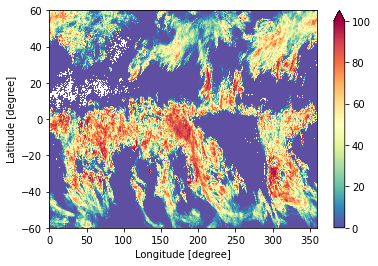

In [11]:
mcspcpfrac_obs.plot(vmin=0, vmax=100, cmap='Spectral_r')

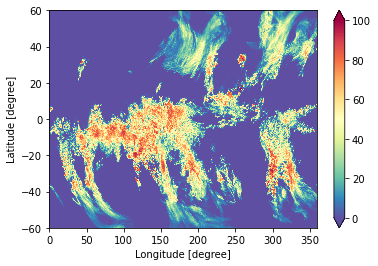

In [12]:
mcspcpfrac_m1.plot(vmin=0, vmax=100, cmap='Spectral_r')

In [13]:
totpcp_diff = totpcp_m1 - totpcp_obs
mcspcp_diff = mcspcp_m1 - mcspcp_obs
mcspcpfrac_diff = mcspcpfrac_m1 - mcspcpfrac_obs

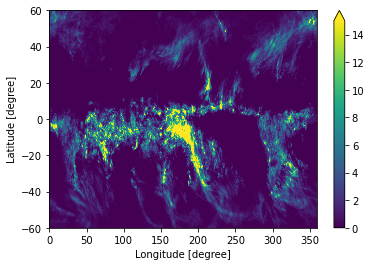

In [14]:
mcspcp_obs.plot(vmin=0, vmax=15)

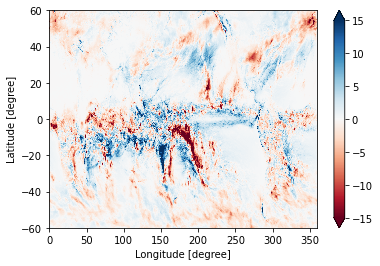

In [15]:
totpcp_diff.plot(vmin=-15, vmax=15, cmap='RdBu')

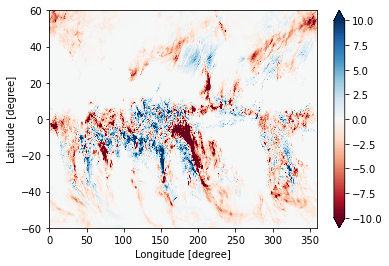

In [16]:
mcspcp_diff.plot(vmin=-10, vmax=10, cmap='RdBu')

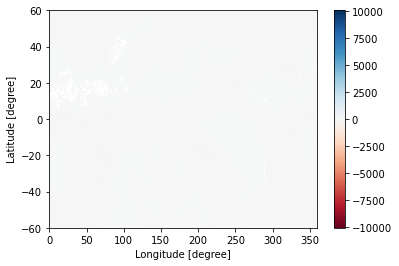

In [17]:
mcspcpfrac_diff.plot(cmap='RdBu')

# Plot single map 

In [18]:
def plot_map_single(dataarray, lon, lat, levels, cmap, cblabel, cbticks, title, figname, 
                    oob_colors=None, mask=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None, text_colors=None,
                    xlabel=True, ylabel=True, colorbar=True, figsize=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [0., 359.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=180)
    levelshgt = [1000,10000]

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=figsize, dpi=100)
    ax = plt.subplot(111, projection=proj)
    ax.set_extent(map_extend, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    # ax.set_title(title, loc='left')
    ax.set_aspect('auto', adjustable=None) 
    flabel = ax.text(0.02, 0.05, title, transform=ax.transAxes, fontsize=14)
    flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))

    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    if xlabel is True:
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(lonv, crs=ccrs.PlateCarree())
    if ylabel is True:
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticks(latv, crs=ccrs.PlateCarree())

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=ccrs.PlateCarree(), zorder=3)

    # Plot data
    cmap = copy.copy(mpl.cm.get_cmap(cmap))
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    Zm = np.ma.masked_invalid(dataarray)
    # Zm1s = gaussian_filter(Zm1, 0.5)
    if (contourf == False):
        pcm1 = ax.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
    else:
        pcm1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)
        
    # Set out of bound colors
    if oob_colors is not None:
        pcm1.cmap.set_over(oob_colors['over'])
        pcm1.cmap.set_under(oob_colors['under'])
        pcm1.set_clim(min(levels), max(levels))
    # Plot colorbar
    if colorbar == True:
        if (contourf == False):
            cb = plt.colorbar(pcm1, label=cblabel, pad=0.02, ticks=cbticks, extend='both')
        else:
            cb = plt.colorbar(pcm1, label=cblabel, pad=0.02, ticks=cbticks)

    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            box = sgeom.box(minx=boxes[ii][0], maxx=boxes[ii][1], miny=boxes[ii][2], maxy=boxes[ii][3])
            ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, zorder=5)
            text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
            ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                    bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                    fontsize=12, fontweight='bold', color=text_color, transform=ccrs.PlateCarree(), zorder=4)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

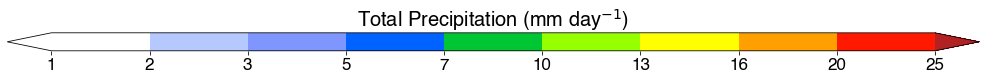

In [19]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = generate_NCL_cmap('precip3_16lev')
oob_colors = {'under':'white', 'over':'firebrick'}
cmap.set_over(oob_colors['over'])
cmap.set_under(oob_colors['under'])
levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = 'Total Precipitation (mm day$^{-1}$)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.ax.set_title(cblabel, size=20)
figname = f'{figdir}globalmap_total_rain_obs_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

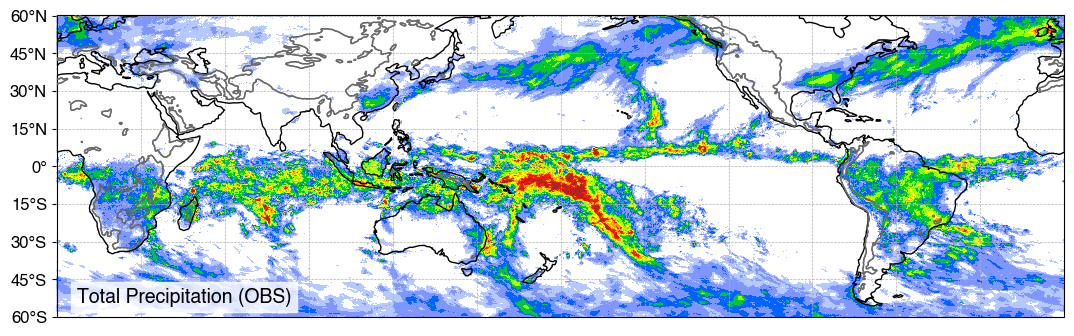

In [20]:
title = 'Total Precipitation (OBS)'
levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = levels
cblabel = 'Total Precipitation (mm day$^{-1}$)'
cmap = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
figname = f'{figdir}globalmap_total_rain_obs.png'
oob_colors = {'under':'white', 'over':'firebrick'}
fig = plot_map_single(totpcp_obs, lon_obs, lat_obs, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=False, xlabel=False, colorbar=False, figsize=[13,4])

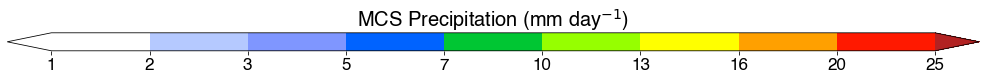

In [21]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = generate_NCL_cmap('precip3_16lev')
oob_colors = {'under':'white', 'over':'firebrick'}
cmap.set_over(oob_colors['over'])
cmap.set_under(oob_colors['under'])
levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = 'MCS Precipitation (mm day$^{-1}$)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.ax.set_title(cblabel, size=20)
figname = f'{figdir}globalmap_mcs_rain_obs_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

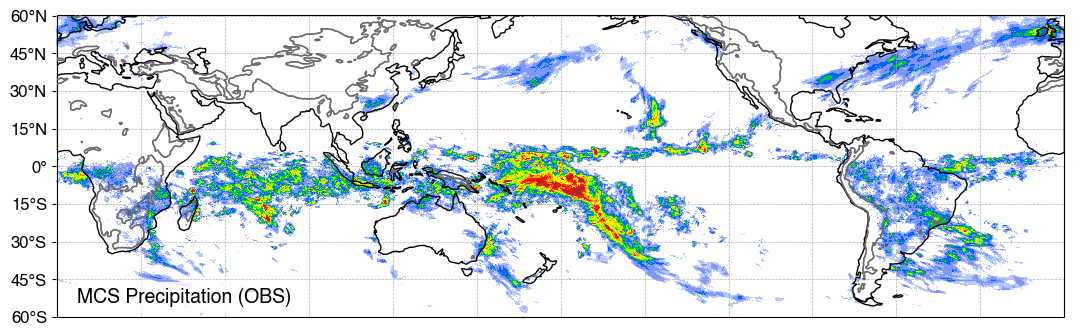

In [22]:
title = 'MCS Precipitation (OBS)'
levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = levels
cblabel = 'MCS Precipitation (mm day$^{-1}$)'
cmap = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
figname = f'{figdir}globalmap_mcs_rain_obs.png'
oob_colors = {'under':'white', 'over':'firebrick'}
fig = plot_map_single(mcspcp_obs, lon_obs, lat_obs, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=False, xlabel=False, colorbar=False, figsize=[13,4])

In [23]:
box_mc = [95,150,-20,5]
box_itcz = [151,250,0,12]
box_spcz = [151,210,-30,-1]
box_io = [50,94,-15,5]
box_afc = [10,40,-20,5]
box_amz = [-75%360,-40%360,-20,0]
box_ao = [-40%360,-10%360,-8,8]
box_amz180 = [-75,-40,-20,0]
box_ao180 = [-40,-10,-8,8]
boxes = {'maritime_continent':box_mc, 
         'itcz':box_itcz, 
         'spcz':box_spcz, 
         'indian_ocean':box_io, 
         'africa':box_afc, 
         'amazon':box_amz, 
         'atlantic_ocean':box_ao}
# For plotting only
boxes4plot = copy.deepcopy(boxes)
boxes4plot['amazon'] = box_amz180
boxes4plot['atlantic_ocean'] = box_ao180
boxes['amazon'][0]
# box_amz

285

In [24]:
# Calculate regional mean difference
diff_tot_reg = np.zeros(len(boxes), dtype=float)
diff_mcs_reg = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)
for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lon_obs >= boxes[name][0]) & (lon_obs <= boxes[name][1]))[0]
    yid = np.where((lat_obs >= boxes[name][2]) & (lat_obs <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    tot_mod = totpcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    tot_obs = totpcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    diff_tot_reg[ii] = 100 * (np.nansum(tot_mod) - np.nansum(tot_obs)) / np.nansum(tot_obs)
    mcs_mod = mcspcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    mcs_obs = mcspcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    diff_mcs_reg[ii] = 100 * (np.nansum(mcs_mod) - np.nansum(mcs_obs)) / np.nansum(mcs_obs)
# print('Total:', diff_tot_reg)
# print('MCS:', diff_mcs_reg)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_tot = dict(zip(boxes.keys(), diff_tot_reg))
text_val_mcs = dict(zip(boxes.keys(), diff_mcs_reg))
# text_val = [text_val_tot, text_val_mcs]
# print(text_loc)
# print(text_val)

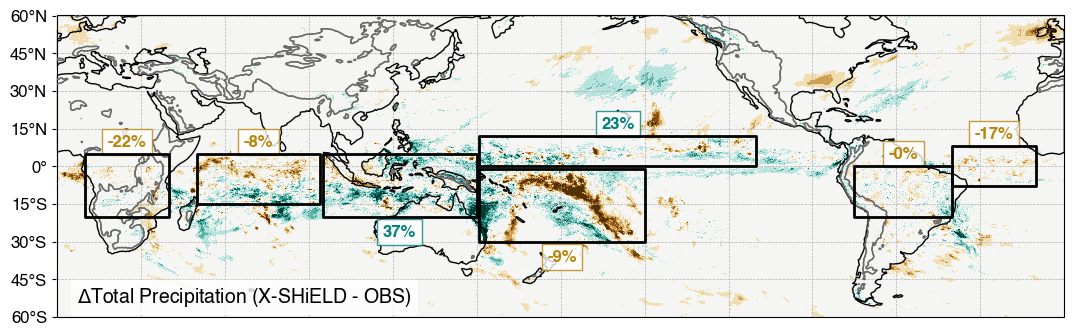

In [25]:
title = f'$\Delta$Total Precipitation ({model_name[run_name]} - OBS)'
levels = [-20,-16,-12,-8,-4,4,8,12,16,20]
cbticks = levels
cblabels = '$\Delta$Total Rain (mm day$^{-1}$)'
cmap = 'BrBG'
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
figname = f'{figdir}globalmap_total_rain_diff_{run_name}.png'
fig = plot_map_single(totpcp_diff, lon_obs, lat_obs, levels, cmap, cblabel, cbticks, title, figname, 
                      contourf=False, xlabel=xlabel_m, colorbar=False, figsize=[13,4],
                      boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val_tot, text_colors=text_colors)

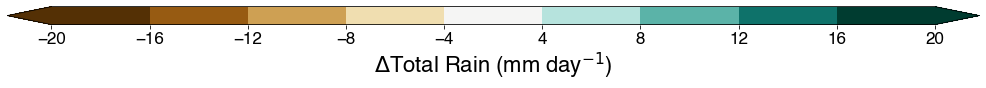

In [26]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = copy.copy(mpl.cm.get_cmap('BrBG'))
levels = [-20,-16,-12,-8,-4,4,8,12,16,20]
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = '$\Delta$Total Rain (mm day$^{-1}$)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.set_label(label=cblabel, size=22)
figname = f'{figdir}globalmap_total_rain_diff_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

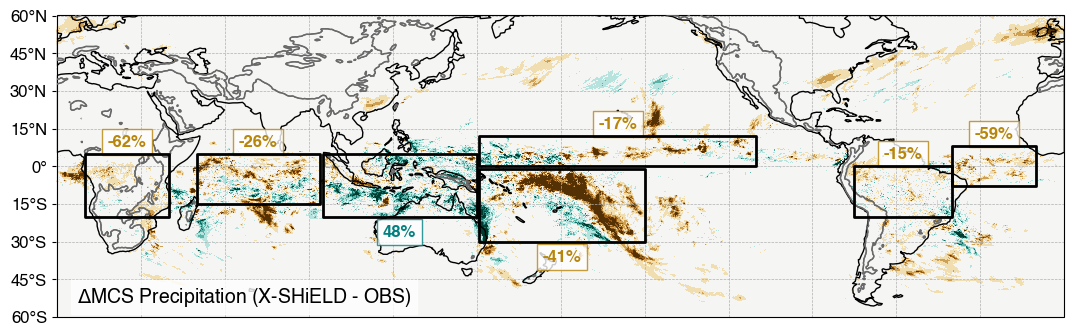

In [27]:
title = f'$\Delta$MCS Precipitation ({model_name[run_name]} - OBS)'
levels = [-15,-12,-9,-6,-3,3,6,9,12,15]
cbticks = levels
cblabels = '$\Delta$MCS Rain (mm day$^{-1}$)'
cmap = 'BrBG'
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
figname = f'{figdir}globalmap_mcs_rain_diff_{run_name}.png'
fig = plot_map_single(mcspcp_diff, lon_obs, lat_obs, levels, cmap, cblabel, cbticks, title, figname, 
                      contourf=False, xlabel=xlabel_m, colorbar=False, figsize=[13,4],
                      boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val_mcs, text_colors=text_colors)

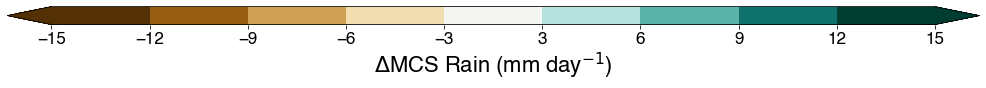

In [28]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = copy.copy(mpl.cm.get_cmap('BrBG'))
levels = [-15,-12,-9,-6,-3,3,6,9,12,15]
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = '$\Delta$MCS Rain (mm day$^{-1}$)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.set_label(label=cblabel, size=22)
figname = f'{figdir}globalmap_mcs_rain_diff_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [29]:
# Calculate regional mean difference
mcspcpfrac_reg_obs = np.zeros(len(boxes), dtype=float)
mcspcpfrac_reg_m1 = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)
for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lon_obs >= boxes[name][0]) & (lon_obs <= boxes[name][1]))[0]
    yid = np.where((lat_obs >= boxes[name][2]) & (lat_obs <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    tot_mod = totpcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    tot_obs = totpcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    mcs_mod = mcspcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    mcs_obs = mcspcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    mcspcpfrac_reg_obs[ii] = 100 * np.nansum(mcs_obs) / np.nansum(tot_obs)
    mcspcpfrac_reg_m1[ii] = 100 * np.nansum(mcs_mod) / np.nansum(tot_mod)   
    # print(f'{diff_reg:.00f}%')
# print('MCS rainfrac (OBS):', mcspcpfrac_reg_obs)
# print(f'MCS rainfrac ({model_name[run_name]}):', mcspcpfrac_reg_m1)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_obs = dict(zip(boxes.keys(), mcspcpfrac_reg_obs))
text_val_m1 = dict(zip(boxes.keys(), mcspcpfrac_reg_m1))
print(text_val_m1)
# text_val = [text_val_obs, text_val_m1]
# print(text_loc)
# print(text_val)

{'maritime_continent': 61.98092276918776, 'itcz': 42.48730779013786, 'spcz': 45.696750067276646, 'indian_ocean': 57.4143730629329, 'africa': 24.411620883672185, 'amazon': 40.55500143794995, 'atlantic_ocean': 30.91805837623249}


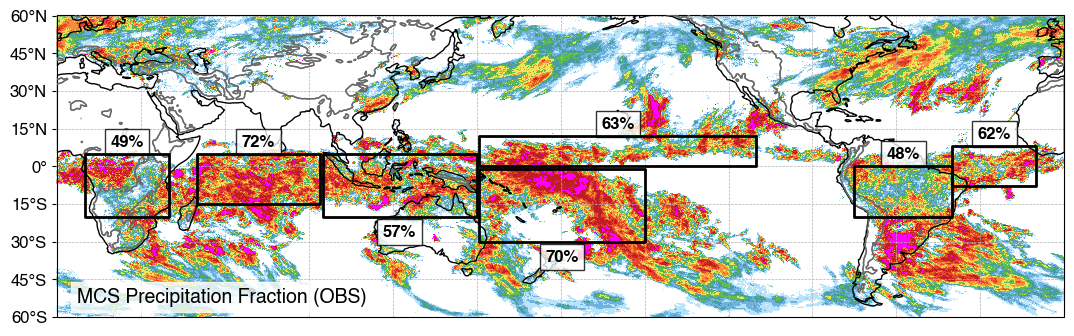

In [30]:
title = f'MCS Precipitation Fraction (OBS)'
levels = np.arange(0, 90.01, 10)
cbticks = levels
cblabel = 'MCS Precipitation Fraction (%)'
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap = truncate_colormap(cmap, 0.0, 0.9)
oob_colors = {'under':'white', 'over':'magenta'}
text_colors = {'pos':'k', 'neg':'k'}
figname = f'{figdir}globalmap_mcs_rainfrac_obs.png'
fig = plot_map_single(mcspcpfrac_obs, lon_obs, lat_obs, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=False, xlabel=False, colorbar=False, figsize=[13,4],
                      boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val_obs, text_colors=text_colors)

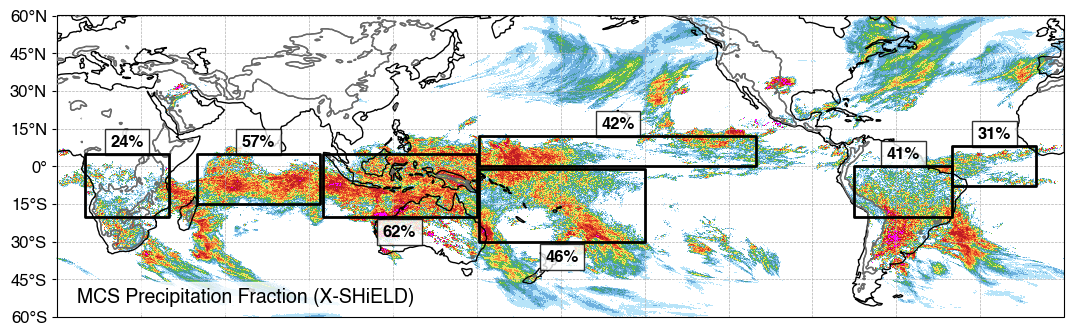

In [31]:
title = f'MCS Precipitation Fraction ({model_name[run_name]})'
levels = np.arange(0, 90.01, 10)
cbticks = levels
cblabel = 'MCS Precipitation Fraction (%)'
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap = truncate_colormap(cmap, 0.0, 0.9)
oob_colors = {'under':'white', 'over':'magenta'}
text_colors = {'pos':'k', 'neg':'k'}
figname = f'{figdir}globalmap_mcs_rainfrac_{run_name}.png'
fig = plot_map_single(mcspcpfrac_m1, lon_obs, lat_obs, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=False, xlabel=xlabel_m, colorbar=False, figsize=[13,4],
                      boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val_m1, text_colors=text_colors)

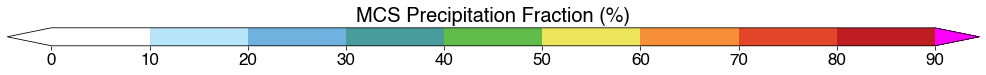

In [32]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap = truncate_colormap(cmap, 0.0, 0.9)
cmap.set_over('magenta')
cmap.set_under('white')
levels = np.arange(0, 90.01, 10)
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = 'MCS Precipitation Fraction (%)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.ax.set_title(cblabel, size=20)
figname = f'{figdir}globalmap_mcs_rainfrac_obs_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

# Plot two maps

In [33]:
def plot_2maps_1cb(dataarray, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                   oob_colors=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None, text_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [0., 359.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=180)
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,8], dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    # text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
    
    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp], projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
        # Lat/lon grid
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)           
        if (pp == 1):
            ax.set_xticks(lonv, crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=ccrs.PlateCarree(), zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = copy.copy(mpl.cm.get_cmap(cmap))
        norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)
        # Set out-of-bound colors
        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels), max(levels))

        # Plot boxes
        if boxes is not None:
            for ii in boxes:
                box = sgeom.box(minx=boxes[ii][0], maxx=boxes[ii][1], miny=boxes[ii][2], maxy=boxes[ii][3])
                ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, zorder=5)
                text_color = text_colors['pos'] if (boxtext[pp][ii] >=0) else text_colors['neg']
                # text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]:.00f}%", ha='center',
                    bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                    fontsize=12, fontweight='bold', color=text_color, transform=ccrs.PlateCarree(), zorder=4)

    # Plot 1 colorbar by manually adding a new axes
    cax1 = fig.add_axes([0.90, 0.1, 0.02, 0.8])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabel, ticks=cbticks, orientation='vertical', extend='both')
    cb1.set_label(cblabel, fontsize=14)
    cb1.ax.tick_params(labelsize=14)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [34]:
# box_mc = [95,150,-20,5]
# box_itcz = [151,250,0,12]
# box_spcz = [151,210,-30,-1]
# box_io = [50,94,-15,5]
# box_afc = [10,40,-20,5]
# box_amz = [-75%360,-40%360,-20,0]
# box_ao = [-40%360,-10%360,-8,8]
# box_amz180 = [-75,-40,-20,0]
# box_ao180 = [-40,-10,-8,8]
# boxes = {'maritime_continent':box_mc, 
#          'itcz':box_itcz, 
#          'spcz':box_spcz, 
#          'indian_ocean':box_io, 
#          'africa':box_afc, 
#          'amazon':box_amz, 
#          'atlantic_ocean':box_ao}
# # For plotting only
# boxes4plot = copy.deepcopy(boxes)
# boxes4plot['amazon'] = box_amz180
# boxes4plot['atlantic_ocean'] = box_ao180
# boxes['amazon'][0]
# # box_amz

In [35]:
# boxes

In [36]:
# Calculate regional mean difference
mcspcpfrac_reg_obs = np.zeros(len(boxes), dtype=float)
mcspcpfrac_reg_m1 = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)
for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lon_obs >= boxes[name][0]) & (lon_obs <= boxes[name][1]))[0]
    yid = np.where((lat_obs >= boxes[name][2]) & (lat_obs <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    tot_mod = totpcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    tot_obs = totpcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    mcs_mod = mcspcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    mcs_obs = mcspcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    mcspcpfrac_reg_obs[ii] = 100 * np.nansum(mcs_obs) / np.nansum(tot_obs)
    mcspcpfrac_reg_m1[ii] = 100 * np.nansum(mcs_mod) / np.nansum(tot_mod)
    # print(f'{diff_reg:.00f}%')
print('MCS rainfrac (OBS):', mcspcpfrac_reg_obs)
print(f'MCS rainfrac ({model_name[run_name]}):', mcspcpfrac_reg_m1)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_obs = dict(zip(boxes.keys(), mcspcpfrac_reg_obs))
text_val_m1 = dict(zip(boxes.keys(), mcspcpfrac_reg_m1))
text_val = [text_val_obs, text_val_m1]
# print(text_loc)
print(text_val)

MCS rainfrac (OBS): [57.26302116 62.90194559 70.23490253 71.86598841 49.45196262 47.76092126
 61.97102929]
MCS rainfrac (X-SHiELD): [61.98092277 42.48730779 45.69675007 57.41437306 24.41162088 40.55500144
 30.91805838]
[{'maritime_continent': 57.263021163249434, 'itcz': 62.901945588254215, 'spcz': 70.23490253288065, 'indian_ocean': 71.86598841040596, 'africa': 49.451962623314344, 'amazon': 47.760921255602895, 'atlantic_ocean': 61.971029289852645}, {'maritime_continent': 61.98092276918776, 'itcz': 42.48730779013786, 'spcz': 45.696750067276646, 'indian_ocean': 57.4143730629329, 'africa': 24.411620883672185, 'amazon': 40.55500143794995, 'atlantic_ocean': 30.91805837623249}]


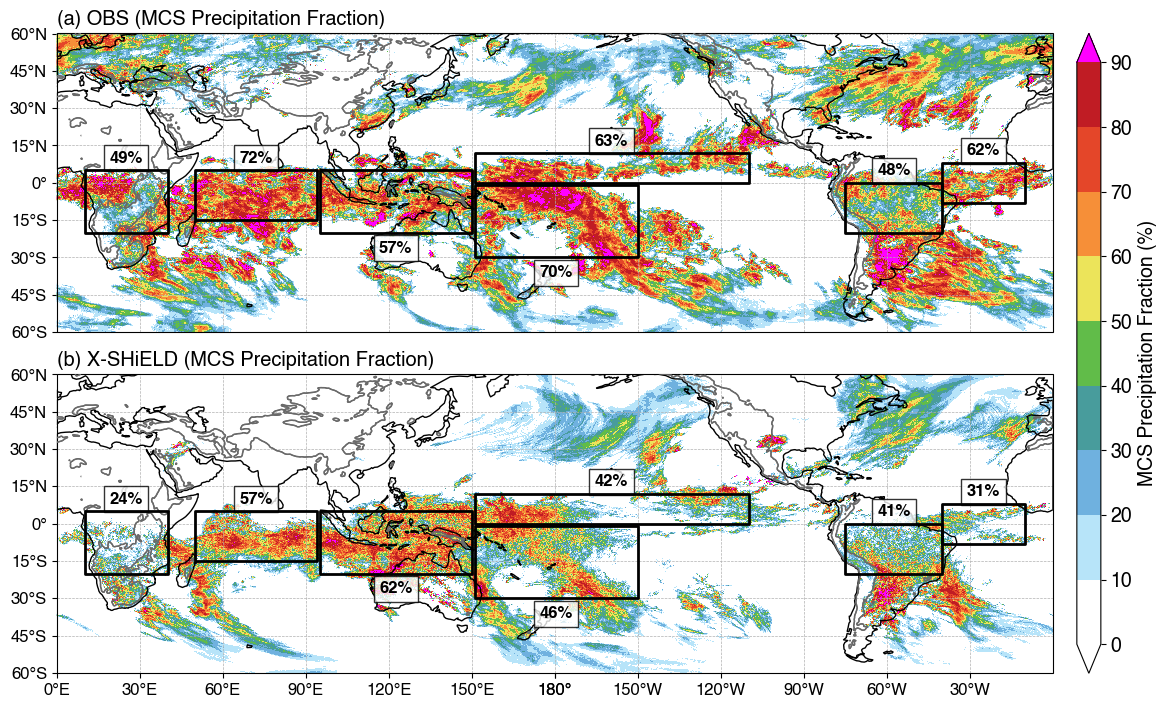

In [37]:
titles = [f'(a) OBS (MCS Precipitation Fraction)',f'(b) {model_name[run_name]} (MCS Precipitation Fraction)']
dataarr = [mcspcpfrac_obs, mcspcpfrac_m1]
levels = np.arange(0, 90.01, 10)
cbticks = levels
cblabel = 'MCS Precipitation Fraction (%)'
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap = truncate_colormap(cmap, 0.0, 0.9)
figname = f'{figdir}globalmap_mcs_rainfrac_obs_{run_name}.png'
oob_colors = {'under':'white', 'over':'magenta'}
text_colors = {'pos':'k', 'neg':'k'}
fig = plot_2maps_1cb(dataarr, lon_obs, lat_obs, titles, levels, cmap, cblabel, cbticks, figname, 
                     contourf=False, oob_colors=oob_colors,
                     boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors)

In [38]:
def plot_2maps_2cb(dataarray, lon, lat, titles, levels, cmap, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None, text_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [0., 359.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=180)
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,8], dpi=100)
    gs = gridspec.GridSpec(2,2, height_ratios=[1,1], width_ratios=[1,0.02])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp,0], projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
#         ax.add_feature(land, facecolor='lightgray')
#         ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])

        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)
            
        if (pp == 1):
            ax.set_xticks(lonv, crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=ccrs.PlateCarree(), zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = copy.copy(mpl.cm.get_cmap(cmap))
        norm = colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
        
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels[pp], norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)

        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))

        # Plot boxes
        if boxes is not None:
            for ii in boxes:
                box = sgeom.box(minx=boxes[ii][0], maxx=boxes[ii][1], miny=boxes[ii][2], maxy=boxes[ii][3])
                ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, zorder=5)
                text_color = text_colors['pos'] if (boxtext[pp][ii] >=0) else text_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]:.00f}%", ha='center',
                    bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                    fontsize=12, fontweight='bold', color=text_color, transform=ccrs.PlateCarree(), zorder=4)
                
        # Colorbars
        cax1 = plt.subplot(gs[pp,1])
        cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[pp], ticks=cbticks[pp], orientation='vertical', extend='both')
        # cb1.set_label(cblabel, fontsize=14)
        cb1.ax.tick_params(labelsize=14)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [39]:
# Calculate regional mean difference
diff_tot_reg = np.zeros(len(boxes), dtype=float)
diff_mcs_reg = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)
for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lon_obs >= boxes[name][0]) & (lon_obs <= boxes[name][1]))[0]
    yid = np.where((lat_obs >= boxes[name][2]) & (lat_obs <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    tot_mod = totpcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    tot_obs = totpcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    diff_tot_reg[ii] = 100 * (np.nansum(tot_mod) - np.nansum(tot_obs)) / np.nansum(tot_obs)
    mcs_mod = mcspcp_m1.values[min(yid):max(yid), min(xid):max(xid)]
    mcs_obs = mcspcp_obs.values[min(yid):max(yid), min(xid):max(xid)]
    diff_mcs_reg[ii] = 100 * (np.nansum(mcs_mod) - np.nansum(mcs_obs)) / np.nansum(mcs_obs)
# print('Total:', diff_tot_reg)
# print('MCS:', diff_mcs_reg)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_tot = dict(zip(boxes.keys(), diff_tot_reg))
text_val_mcs = dict(zip(boxes.keys(), diff_mcs_reg))
text_val = [text_val_tot, text_val_mcs]
# print(text_loc)
print(text_val)

[{'maritime_continent': 36.58330651455361, 'itcz': 22.539522674479173, 'spcz': -8.68678636105214, 'indian_ocean': -7.8465982423577625, 'africa': -22.108763226767508, 'amazon': -0.010294154105260824, 'atlantic_ocean': -16.969943348315415}, {'maritime_continent': 47.83640822066715, 'itcz': -17.23031191424118, 'spcz': -40.589123768693646, 'indian_ocean': -26.377833178657028, 'africa': -61.54952723004668, 'amazon': -15.096221811576818, 'atlantic_ocean': -58.57535096711674}]


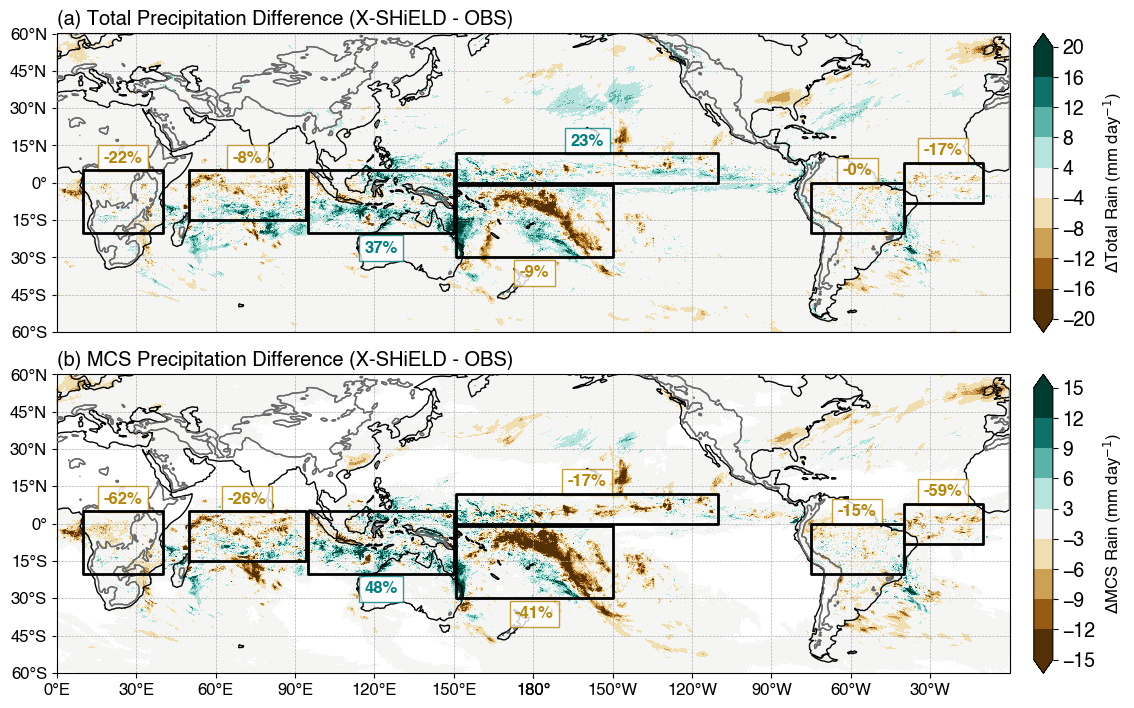

In [40]:
titles = [f'(a) Total Precipitation Difference ({model_name[run_name]} - OBS)',f'(b) MCS Precipitation Difference ({model_name[run_name]} - OBS)']
dataarr = [totpcp_diff, mcspcp_diff]
lev1 = [-20,-16,-12,-8,-4,4,8,12,16,20]
lev2 = [-15,-12,-9,-6,-3,3,6,9,12,15]
cbticks1 = lev1
cbticks2 = lev2
levels = [lev1, lev2]
cbticks = [cbticks1, cbticks2]
cblabels = ['$\Delta$Total Rain (mm day$^{-1}$)', '$\Delta$MCS Rain (mm day$^{-1}$)']
cmap = 'BrBG'
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
figname = f'{figdir}globalmap_total_mcs_rain_diff_{run_name}.png'
fig = plot_2maps_2cb(dataarr, lon_obs, lat_obs, titles, levels, cmap, cblabels, cbticks, figname, contourf=False,
                     boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors)

In [41]:
figdir

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/'

In [42]:
def plot_2maps(dataarray, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
               oob_colors=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [0., 359.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=180)
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,8], dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
    
    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp], projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)

        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)
            
        if (pp == 1):
            ax.set_xticks(lonv, crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=ccrs.PlateCarree(), zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = copy.copy(mpl.cm.get_cmap(cmap))
        norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
        
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)

        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels), max(levels))

        # Plot boxes
        if boxes is not None:
            for ii in boxes:
                box = sgeom.box(minx=boxes[ii][0], maxx=boxes[ii][1], miny=boxes[ii][2], maxy=boxes[ii][3])
                ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, zorder=5)
                # text_color = text_colors['pos'] if (boxtext[pp][ii] >=0) else text_colors['neg']
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]}", ha='center',
                    bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                    fontsize=12, fontweight='bold', color=text_color, transform=ccrs.PlateCarree(), zorder=4)

    # Plot 1 colorbar by manually adding a new axes
    cax1 = fig.add_axes([0.90, 0.1, 0.02, 0.8])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabel, ticks=cbticks, orientation='vertical', extend='both')
    cb1.set_label(cblabel, fontsize=14)
    cb1.ax.tick_params(labelsize=14)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [43]:
# Calculate regional mean
tot_mod_reg = []
tot_obs_reg = []
text_loc_x = np.zeros(len(boxes), dtype=float)
for ii, name in enumerate(boxes):
    # Subset region
    xid = np.where((lon_obs >= boxes[name][0]) & (lon_obs <= boxes[name][1]))[0]
    yid = np.where((lat_obs >= boxes[name][2]) & (lat_obs <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean
    tot_mod = totpcp_m1.data[min(yid):max(yid), min(xid):max(xid)]
    tot_obs = totpcp_obs.data[min(yid):max(yid), min(xid):max(xid)]
    tot_mod_reg.append(f'{np.nanmean(tot_mod):.1f} mm/d')
    tot_obs_reg.append(f'{np.nanmean(tot_obs):.1f} mm/d')
# print('OBS:', tot_mod_reg)
# print('MODEL:', tot_obs_reg)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_obs = dict(zip(boxes.keys(), tot_obs_reg))
text_val_mod = dict(zip(boxes.keys(), tot_mod_reg))
text_val = [text_val_obs, text_val_mod]
print(text_val)

[{'maritime_continent': '6.4 mm/d', 'itcz': '5.6 mm/d', 'spcz': '8.8 mm/d', 'indian_ocean': '7.7 mm/d', 'africa': '4.8 mm/d', 'amazon': '7.6 mm/d', 'atlantic_ocean': '4.7 mm/d'}, {'maritime_continent': '8.7 mm/d', 'itcz': '6.9 mm/d', 'spcz': '8.1 mm/d', 'indian_ocean': '7.1 mm/d', 'africa': '3.7 mm/d', 'amazon': '7.6 mm/d', 'atlantic_ocean': '3.9 mm/d'}]


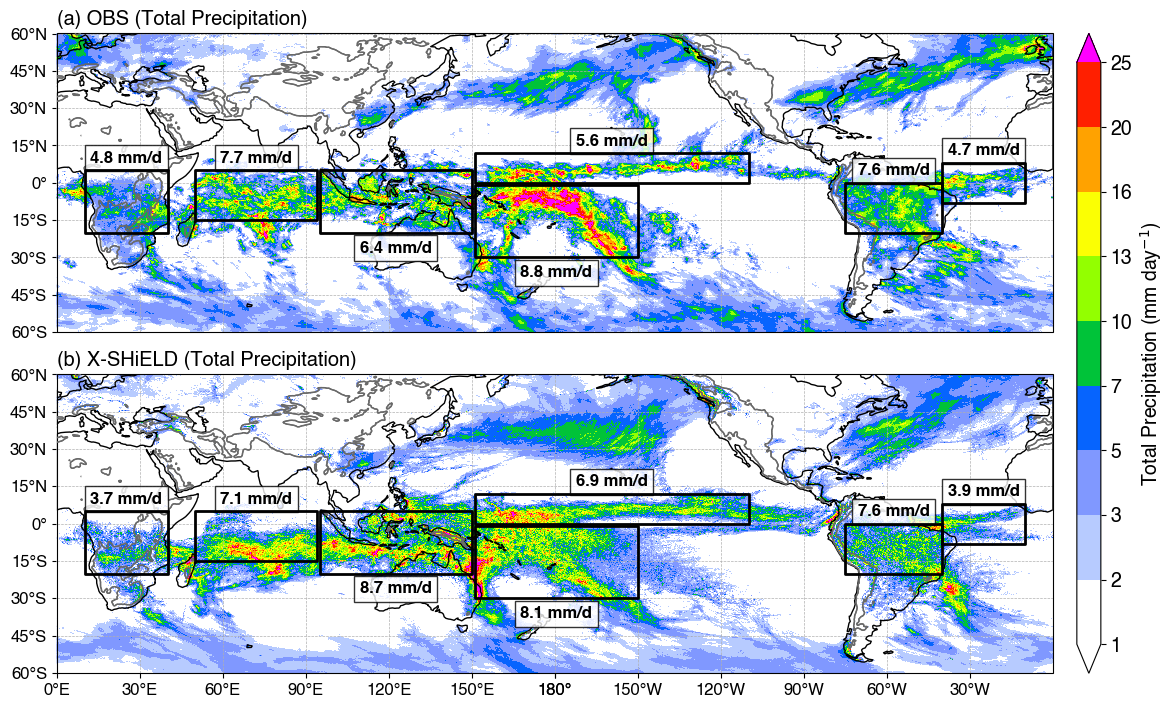

In [44]:
titles = [f'(a) OBS (Total Precipitation)',f'(b) {model_name[run_name]} (Total Precipitation)']
dataarr = [totpcp_obs, totpcp_m1]
levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = levels
cblabel = 'Total Precipitation (mm day$^{-1}$)'
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmap = truncate_colormap(cmap, 0., 0.9)
figname = f'{figdir}globalmap_total_rain_obs_{run_name}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_2maps(dataarr, lon_obs, lat_obs, titles, levels, cmap, cblabel, cbticks, figname, oob_colors=oob_colors, contourf=False,
                boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val)

In [45]:
# Calculate regional mean
mcs_mod_reg = []
mcs_obs_reg = []
text_loc_x = np.zeros(len(boxes), dtype=float)
for ii, name in enumerate(boxes):
    # Subset region
    xid = np.where((lon_obs >= boxes[name][0]) & (lon_obs <= boxes[name][1]))[0]
    yid = np.where((lat_obs >= boxes[name][2]) & (lat_obs <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean
    mcs_mod = mcspcp_m1.data[min(yid):max(yid), min(xid):max(xid)]
    mcs_obs = mcspcp_obs.data[min(yid):max(yid), min(xid):max(xid)]
    mcs_mod_reg.append(f'{np.nanmean(mcs_mod):.1f} mm/d')
    mcs_obs_reg.append(f'{np.nanmean(mcs_obs):.1f} mm/d')
# print('OBS:', mcs_mod_reg)
# print('MODEL:', mcs_obs_reg)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_obs = dict(zip(boxes.keys(), mcs_obs_reg))
text_val_mod = dict(zip(boxes.keys(), mcs_mod_reg))
text_val = [text_val_obs, text_val_mod]
print(text_val)

[{'maritime_continent': '3.6 mm/d', 'itcz': '3.6 mm/d', 'spcz': '6.2 mm/d', 'indian_ocean': '5.6 mm/d', 'africa': '2.4 mm/d', 'amazon': '3.6 mm/d', 'atlantic_ocean': '2.9 mm/d'}, {'maritime_continent': '5.4 mm/d', 'itcz': '2.9 mm/d', 'spcz': '3.7 mm/d', 'indian_ocean': '4.1 mm/d', 'africa': '0.9 mm/d', 'amazon': '3.1 mm/d', 'atlantic_ocean': '1.2 mm/d'}]


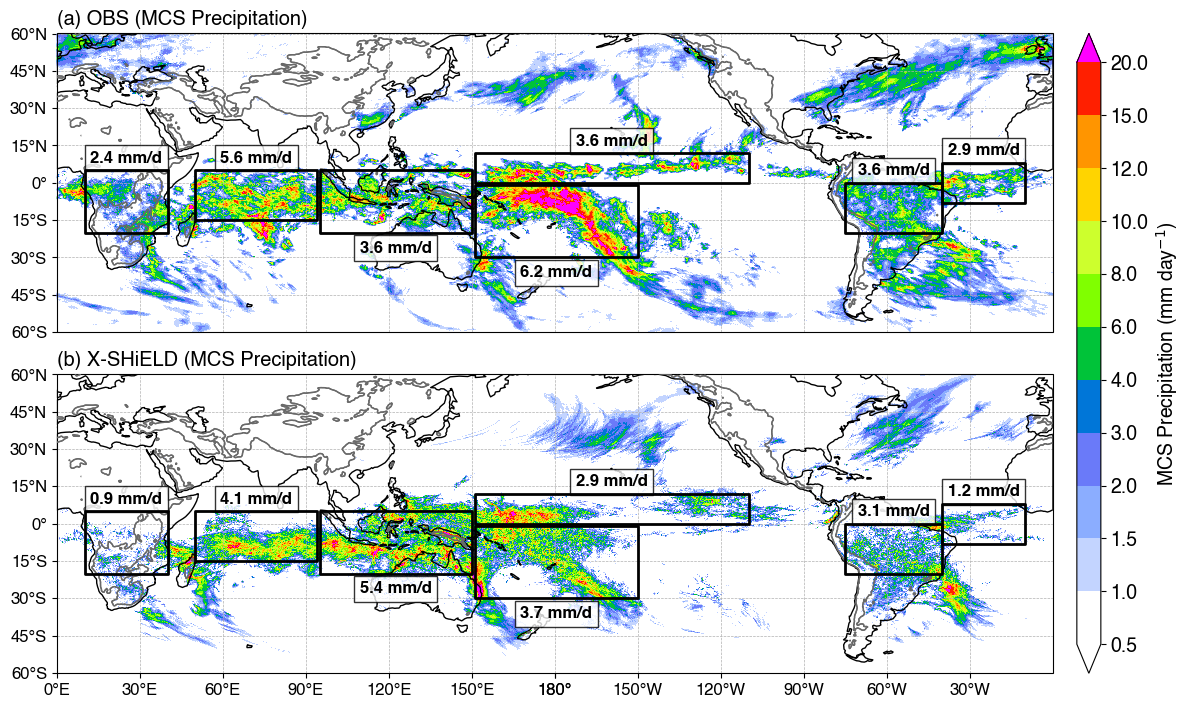

In [46]:
titles = [f'(a) OBS (MCS Precipitation)',f'(b) {model_name[run_name]} (MCS Precipitation)']
dataarr = [mcspcp_obs, mcspcp_m1]
levels = [0.5,1,1.5,2,3,4,6,8,10,12,15,20]
cbticks = levels
cblabel = 'MCS Precipitation (mm day$^{-1}$)'
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmap = truncate_colormap(cmap, 0., 0.9)
figname = f'{figdir}globalmap_mcs_rain_obs_{run_name}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_2maps(dataarr, lon_obs, lat_obs, titles, levels, cmap, cblabel, cbticks, figname, oob_colors=oob_colors, contourf=False, 
                 boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val)